In [11]:
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def to_csv():
    with open('gpu_price.json', 'r') as file:
        data_dict = json.load(file)
        flattened_data = []   
        for key, model_data in data_dict.items():
            model_data['Model name'] = model_data['Model name']
            flattened_data.append(model_data)
        df = pd.DataFrame(flattened_data)
        df.to_csv('gpu_data.csv', index=False)


In [12]:
df = pd.read_csv('gpu_data.csv')
df.head(5)

,Model name,Launch,Code name,Fab (nm),Transistors (million),Die size (mm),Bus interface,Core clock (MHz),Memory clock (MHz),Core config,...,Branding and Model,Branding and Model Branding and Model.1,MSRP (USD),L2 cache,Clock rate (MHz),Processing power (TFLOPS) Half precision (base),Processing power (TFLOPS) Single precision (base),Processing power (TFLOPS) Double precision (base),Processing power (TFLOPS) XMX Half Precision,Processing power (TFLOPS) Bfloat16
0,NV1,1995-05-22 00:00:00,NV1,SGS 500 nm,1.0,90.0,PCI,75,60,1:1:1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Riva 128,1997-08-25 00:00:00,NV3,SGS 350 nm,4.0,90.0,"AGP 1x, PCI",100,100,1:1:1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Riva 128ZX,1998-02-23 00:00:00,NV3,SGS/TSMC 350 nm,4.0,90.0,"AGP 2x, PCI",100,100,1:1:1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Riva TNT,1998-06-15 00:00:00,NV4,TSMC 350 nm,7.0,90.0,"AGP 2x, PCI",90,110,2:2:2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Vanta,1999-03-22 00:00:00,NV6,TSMC 250 nm,NaN,NaN,"AGP 4x, PCI",100,125,2:2:2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
price_cols = [
    c for c in df.columns
    if re.search(r"price|msrp|cost|usd|\$", c, re.IGNORECASE)
]

df[price_cols].isna().mean().sort_values(ascending=False)

MSRP (USD)                              0.994659
Release price (USD) Founders Edition    0.961424
Release price (USD) MSRP                0.951929
Release price (USD)                     0.942433
Release Date & Price                    0.928190
Release Price (USD)                     0.911573
dtype: float64

In [23]:
year_cols = [
    c for c in df.columns
    if re.search(r"year|date|launch|release|announced", c, re.IGNORECASE)
]

df["Launch"].describe()
# df[year_cols].isna().mean().sort_values(ascending=False)

count                    1398
unique                    569
top       2012-01-01 00:00:00
freq                       54
Name: Launch, dtype: object

In [24]:
vendor_cols = [
    c for c in df.columns
    if re.search(r"manufacturer|vendor|brand|company", c, re.IGNORECASE)
]

df[vendor_cols].isna().mean().sort_values(ascending=False)
df["Vendor"].describe()

count       1685
unique         3
top       NVIDIA
freq         872
Name: Vendor, dtype: object

In [27]:
name_cols = [
    c for c in df.columns
    if re.search(r"name|model|product", c, re.IGNORECASE)
]

df[name_cols].isna().mean().sort_values(ascending=False)
df["Model"].tail()

1680                         NaN
1681                         NaN
1682    Data Center GPU Max 1100
1683    Data Center GPU Max 1350
1684    Data Center GPU Max 1550
Name: Model, dtype: str

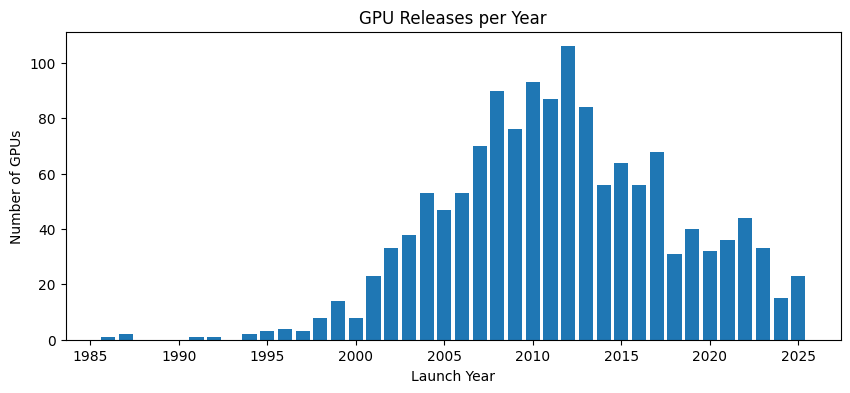

In [28]:
df["Launch"] = pd.to_datetime(df["Launch"], errors="coerce")

df["launch_year"] = df["Launch"].dt.year

year_counts = df["launch_year"].value_counts().sort_index()

plt.figure(figsize=(10, 4))
plt.bar(year_counts.index, year_counts.values)

plt.xlabel("Launch Year")
plt.ylabel("Number of GPUs")
plt.title("GPU Releases per Year")

plt.show()

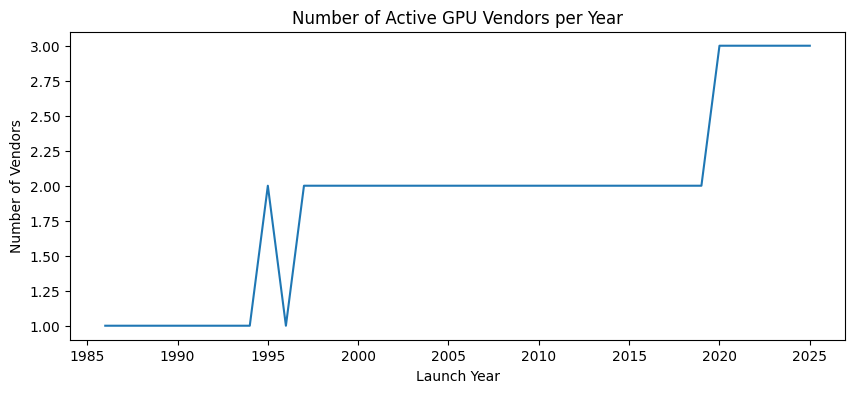

In [29]:
vendors_per_year = (
    df.groupby("launch_year")["Vendor"]
    .nunique()
)

plt.figure(figsize=(10, 4))
plt.plot(vendors_per_year.index, vendors_per_year.values)

plt.xlabel("Launch Year")
plt.ylabel("Number of Vendors")
plt.title("Number of Active GPU Vendors per Year")

plt.show()

In [31]:
price_cols = [
    "MSRP (USD)",
    "Release price (USD) Founders Edition",
    "Release price (USD) MSRP",
    "Release price (USD)",
    "Release Price (USD)"
]

df["price_usd"] = df[price_cols].bfill(axis=1).iloc[:, 0]

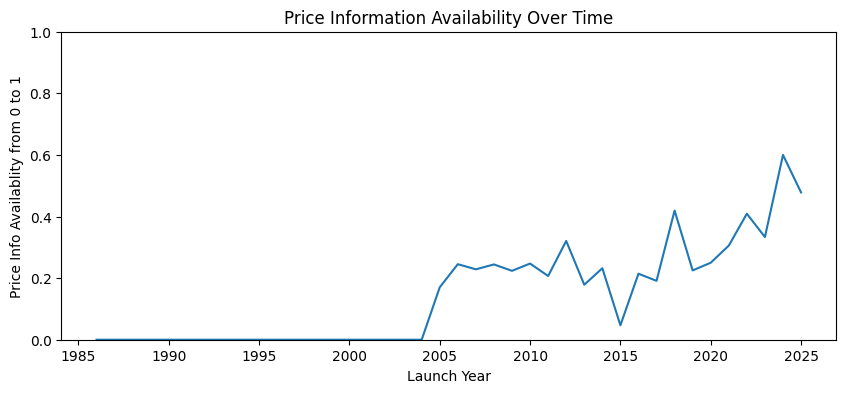

In [35]:
price_available = (
    df.groupby("launch_year")["price_usd"]
    .apply(lambda x: x.notna().mean())
)

plt.figure(figsize=(10, 4))
plt.plot(price_available.index, price_available.values)

plt.xlabel("Launch Year")
plt.ylabel("Price Info Availablity from 0 to 1")
plt.title("Price Information Availability Over Time")

plt.ylim(0, 1)
plt.show()

In [37]:
modern_prices = df[df["price_usd"].notna()]

plt.figure(figsize=(8, 4))
plt.hist(modern_prices["price_usd"], bins=40)

# Choose ~8 clean ticks
min_p = modern_prices["price_usd"].min()
max_p = modern_prices["price_usd"].max()
ticks = np.linspace(min_p, max_p, 8)

plt.xticks(ticks, [f"${int(t):,}" for t in ticks])

plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.title("Distribution of GPU Launch Prices")

plt.tight_layout()
plt.show()

DTypePromotionError: The DType <class 'numpy.dtypes._PyFloatDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes._PyFloatDType'>)

In [ ]:
price_trend = (
    df.groupby("launch_year")["price_usd"]
    .median()
)

plt.figure(figsize=(10, 4))
plt.plot(price_trend.index, price_trend.values)

plt.xlabel("Launch Year")
plt.ylabel("Median Launch Price (USD)")
plt.title("Median GPU Launch Price Over Time")

plt.show()

TypeError: dtype 'str' does not support operation 'median'